<a href="https://colab.research.google.com/github/Ness731/2022-2_Machine_Learning/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
## Word2Vector model : 정적 임베딩 모델
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf # tensorflow 1 버전 사용을 위해 python 다운그레이드 필요
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()

In [5]:
## 1. 모델이 학습할 말뭉치(corpus) 정의
corpus = ['king is a strong man',
          'queen is a wise woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']


## 2. 모델 성능 향상을 위한 문법 요소 제거
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']  # 제거할 문법 요소들
    results = []
    for text in corpus: # corpus 안의 각 문장에 대해
        tmp = text.split(' ')  # 공백 문자 기준으로 토큰화하여 단어 리스트 생성
        for stop_word in stop_words:
            if stop_word in tmp:  # 단어 리스트 안에 제거할 요소가 있다면
                tmp.remove(stop_word)
        results.append(" ".join(tmp)) # 공백 문자를 구분자로 단어 리스트의 모든 요소를 합침
    return results


corpus = remove_stop_words(corpus)

words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word) # 정제된 단어들로 리스트를 생성

words = set(words) # set() : 중복되는 원소를 삭제하는 함수

In [6]:
## 3. 학습 데이터 생성
word2int = {} # 빈 딕셔너리

for i, word in enumerate(words):
    word2int[word] = i # 각 단어들을 매핑되는 인덱스로 변환

sentences = []
for sentence in corpus:
    sentences.append(sentence.split()) # 문장을 단어 단위로 쪼개서 리스트로 구성
# sentences = [['king', 'is', 'a', 'strong', 'man'], ['queen', 'is', 'a', 'wise', 'woman'] ...]

WINDOW_SIZE = 2
data = []
for sentence in sentences: # sentense = 단어가 쪼개져있는 문장 리스트
    for idx, word in enumerate(sentence):
        # sentence[startIndex : endIndex] : 문장 내의 각 단어를 슬라이싱 = sliding window 적용
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0): min(idx + WINDOW_SIZE, len(sentence)) + 1]:
            if neighbor != word: # 타겟 단어일 경우 건너뛰기
                data.append([word, neighbor]) # 타겟 단어와 이웃하는 단어일 경우 테이블에 추가
# data = [['king', 'strong'], ['king', 'man'], ['strong', 'king'], ['strong', 'man'] ...]

df = pd.DataFrame(data, columns = ['input', 'label'])

In [7]:
## 4. 원핫 인코딩
ONE_HOT_DIM = len(words) # 인코딩 벡터 차원은 단어의 개수와 동일 = 12개

# 원핫 인코딩 함수
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM) # 나머지는 0으로 채우기
    one_hot_encoding[data_point_index] = 1 # 인덱스에 해당하는 차원 값만 1로 변환
    return one_hot_encoding

X = [] # input word
Y = [] # target word

# df['input'] = king, king, strong, ...
# df['label'] = strong, man, king, ...
# word2int = 각 단어를 인덱싱한 딕셔너리 = {'boy': 2, 'girl': 10, ...}
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ])) # 'boy'의 경우 [0, 1, 0, ..., 0] 으로 변환
    Y.append(to_one_hot_encoding(word2int[ y ]))


# 모델 학습을 위해 넘파이 행렬로 변환
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# 2차원 시각화를 위해 임베딩 행렬은 2차원으로 구성
EMBEDDING_DIM = 2

# hidden layer에 사용되는 가중치 행렬 W1 초기화
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer에 사용되는 가중치 행렬 W2 초기화
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

In [8]:
## 5. 모델 학습
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

epoch = 20000
for i in range(epoch):
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})

    if i % 3000 == 0:
        print('iteration ' + str(i) + ' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.235706
iteration 3000 loss is :  1.7958575
iteration 6000 loss is :  1.7488321
iteration 9000 loss is :  1.7286115
iteration 12000 loss is :  1.7166026
iteration 15000 loss is :  1.7085935
iteration 18000 loss is :  1.7026875


In [9]:
## 6. 시각화
vectors = sess.run(W1 + b1)

w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = list(words) # set to list
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,pretty,-2.490023,4.696000
1,boy,1.310742,0.214769
2,girl,-0.034430,1.760970
3,woman,-0.289554,0.240904
4,wise,-0.660263,5.642026
5,man,5.606310,2.432386
6,strong,4.386876,-0.664082
7,young,0.207774,0.076531
8,prince,6.348232,2.438151
9,queen,-0.366322,0.774701


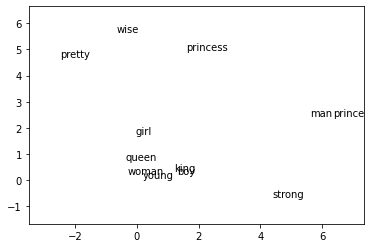

In [10]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

man과 prince가 가까이 있고 queen, woman, girl이 가까이 있는 것을 확인할 수 있다. 성능이 뛰어난 것 같진 않다.